In [158]:
# %pip install ramanspy

In [168]:
import ramanspy as rp
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import re

In [310]:
## Functions for the notebook
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(250, 1200)),
    rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=True)
])

## Functions for the notebook
pipe2 = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(250, 1200)),
    rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
    # rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=True)
])

def load_witec_headlesstxt(filename):
    data = pd.read_table(filename,header=None,names=['Wavenumber', 'Intensity'])

    spectral_axis = data["Wavenumber"]
    spectral_data = data["Intensity"]

    raman_spectrum = rp.Spectrum(spectral_data, spectral_axis)

    return raman_spectrum

def spectral_similarity(spec1, spec2):
    # Interpolate the spectra to have the same spectral axis
    interpolated_spec2 = np.interp(spec1.spectral_axis, spec2.spectral_axis, spec2.spectral_data)
    # Calculate the Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(spec1.spectral_data, interpolated_spec2)
    return correlation_coefficient


# Load RRUFF spectra

In [311]:
# rruff_ex_or=rp.datasets.rruff('excellent_oriented') ## Load from the internet
local_rruff=rp.datasets.rruff(r"C:\Users\charl\Documents\Python dev\raman-peak-id\Files\RRUFF_Raman_532",download=False)
local_rruff_pp=(pipe2.apply(local_rruff[0]),local_rruff[1].copy())

## If you want to use a sub of the database, you can focus on specific minerals below

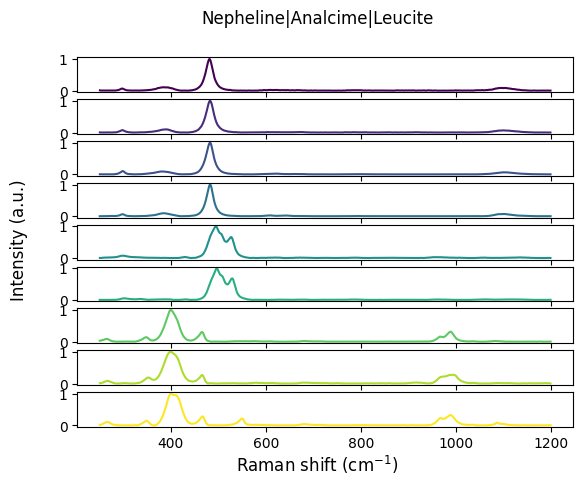

In [312]:
# Define target names
mineral_names = "Nepheline|Analcime|Leucite"#"Ferrosilite|Enstatite"
name_pattern = re.compile(mineral_names)  # Compile regex pattern

db=local_rruff_pp

# Find matching indices
matching_indices = [
    i for i, meta in enumerate(db[1]) 
    if name_pattern.fullmatch(meta.get("##NAMES", ""))
]


# Create sublists
db_sub = (
    [db[0][i] for i in matching_indices],
    [db[1][i] for i in matching_indices] 
)
# Plot the spectra

# db_sub_pp=(pipe2.apply(db_sub[0]),db_sub[1].copy())

rruff_plot = rp.plot.spectra(db_sub_pp[0], plot_type='stacked', title=mineral_names)



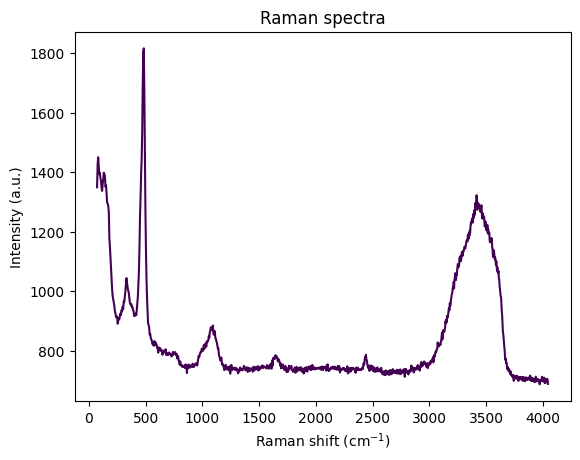

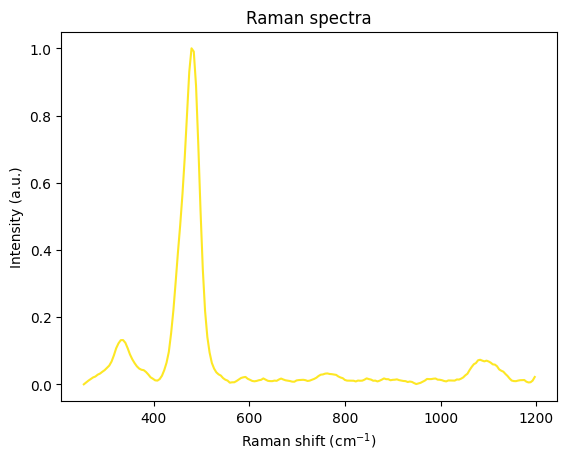

In [333]:
unknown_spectrum=load_witec_headlesstxt(r"C:\Users\charl\Desktop\New folder\3 min2--Spectrum--055--Spec.Data 1 (Demixed).txt")
preprocessed_unknown_spectrum = pipe.apply(unknown_spectrum)

unknown_plot = rp.plot.spectra([unknown_spectrum, preprocessed_unknown_spectrum], plot_type='separate')


<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

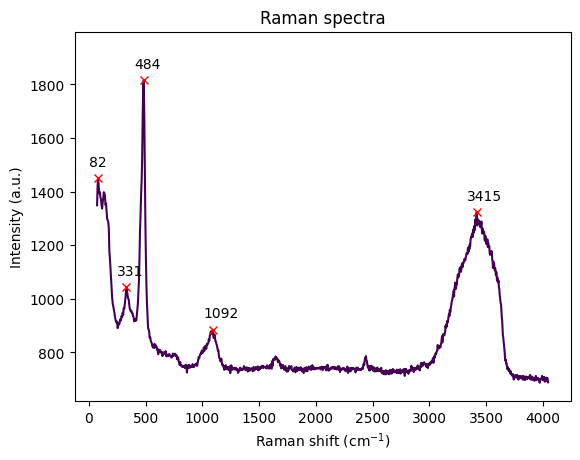

In [338]:
# To show the main peaks in the raw spectrum
rp.plot.peaks(unknown_spectrum, plot_type='separate', prominence=100)

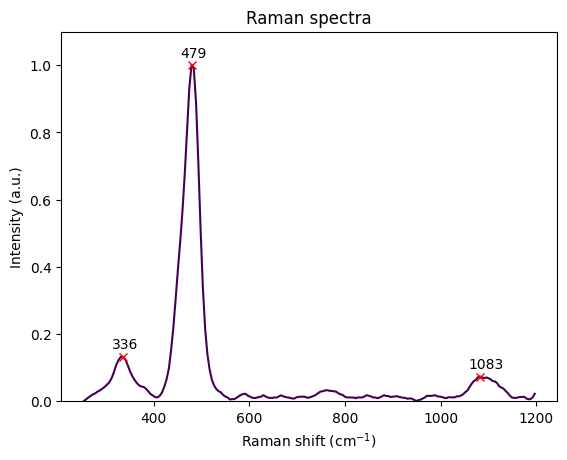

In [339]:
# To show the main peaks in preprocessed spectrum
preprocessed_peaks = rp.plot.peaks(preprocessed_unknown_spectrum, plot_type='separate', prominence=0.05)

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

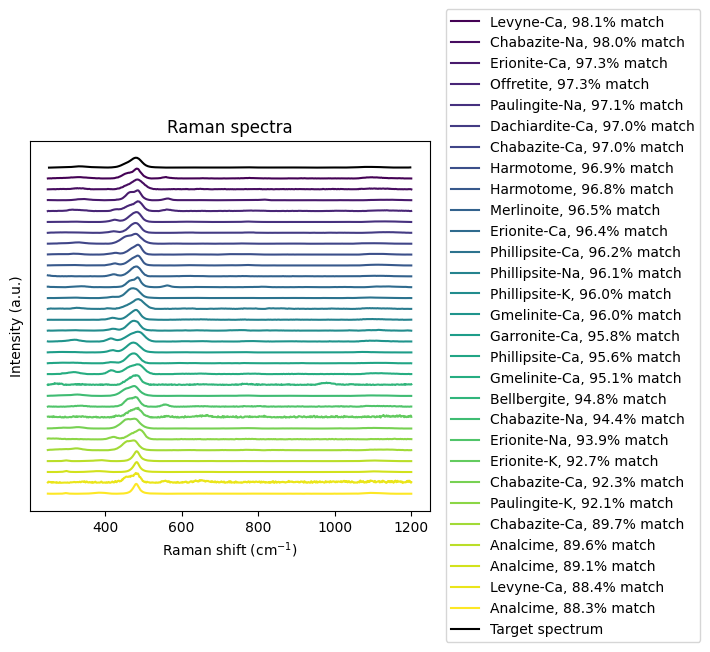

In [342]:
## This calculates the similarity 
database=local_rruff_pp
plot_type='single stacked'
N=30
similarity_scores = []
for index, spectrum in enumerate(database[0]):
    similarity = spectral_similarity(preprocessed_unknown_spectrum, spectrum)
    similarity_scores.append((index, similarity))

similarity_scores.sort(key=lambda x: x[1], reverse=True)
top_matches = similarity_scores[:N]


rp.plot.spectra([database[0][index] for index,_ in top_matches], 
                label=[database[1][index]['##NAMES']+f", {similarity*100:.1f}% match" for index,similarity in top_matches], 
                plot_type=plot_type)

rp.plot.spectra(preprocessed_unknown_spectrum, label="Target spectrum", color='k')


<Axes: title={'center': 'Unknown'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

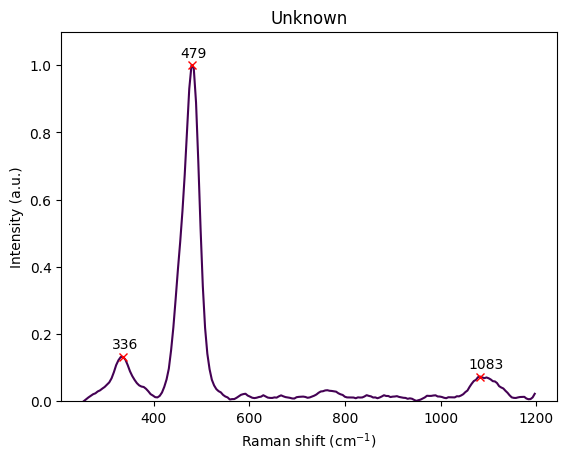

In [320]:
rp.plot.peaks(preprocessed_unknown_spectrum,prominence=0.05,title='Unknown')

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

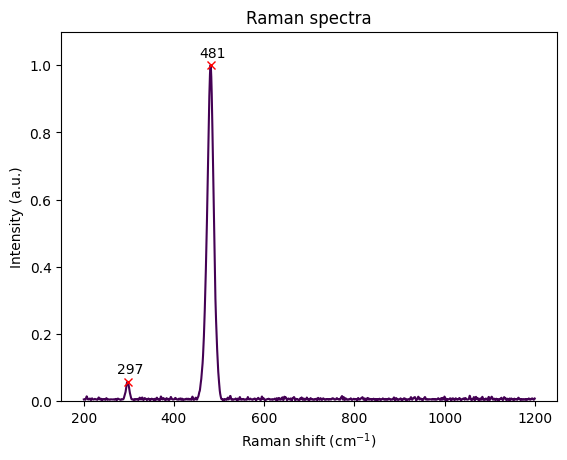

In [273]:
rp.plot.peaks(db_sub_pp[0][0],prominence=0.05)